In [119]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path
import seaborn as sns
import pandas as pd
import sys
sys.path.append('..')
import neatplot
neatplot.set_style()
neatplot.update_rc('font.size', 20)
matplotlib.rcParams['text.usetex'] = True
%matplotlib inline

In [120]:
# sns.set_theme()

In [121]:
base_path = Path('../experiments')
baseline_path = Path('../../bac-baselines/experiments')
process_seeds = False

In [122]:
env_name = 'Pendulum'

In [123]:
pend_paths = {# 'BAC (seed 12)': 'random_init_12_2021-08-05/10-02-01/',
         # 'BAC': 'pend_norm_tele_mg_3mc_2021-08-16/21-16-21',
         #'Rollout BAC': 'rollout_bac_telenorm_multi_2021-08-17/22-44-48/',
         'BARL': 'bac_pendulum_2021-09-30/10-03-18/',
         # 'RQMPC': 'random_pendulum_2021-09-30/13-06-45/',
         'MPC': 'mbrl_pendulum_2021-09-30/12-16-37/',
         r'$EIG_T$': 'us_pendulum_2021-10-02/17-05-00/',
         # 'PETS': 'pets_pendulum_2021-09-26/12-05-56/',
         # 'SAC': 'sac_pendulum_2021-09-30/12-44-00/',
         # 'TD3': 'td3_pendulum_2021-10-01/11-50-44/',
         # 'PPO': 'ppo_pendulum_2021-09-30/15-58-55',
        'Rollout BARL': 'rollout_bac_pendulum_2022-01-24/10-23-32/',
        }

In [124]:
cartpole_paths = {
         # 'BAC': 'cartpole_multistart_2021-08-20/12-52-46/',
         'BARL': 'bac_cartpole_2021-09-30/10-06-18/',
         # 'RQMPC': 'random_cartpole_2021-09-30/14-41-06/',
         'MPC': 'mbrl_cartpole_2021-09-30/14-23-08/',
         r'$EIG_T$': 'us_cartpole_2021-10-02/18-03-05/',
         # 'Rollout BAC': 'cartpole_multistart_rollout_bac_2021-08-19/17-59-03/',
         # 'PETS': 'pets_cartpole_2021-09-26/12-17-26/',
         # 'SAC': 'sac_cartpole_2021-09-30/12-46-23/',
         # 'TD3': 'td3_cartpole_2021-10-01/11-59-14/',
         # 'PPO': 'ppo_cartpole_2021-10-01/13-04-31/',
         'Rollout BARL': 'fast_rollout_bac_cartpole_2022-01-23/12-06-50',
}

In [125]:
lava_paths = {
        # 'BAC': 'bac_lava_path_2021-09-09/10-57-31/',
        'BARL': 'bac_lava_path_2021-09-25/11-47-59/',
        # 'RQMPC': 'random_lava_path_2021-09-30/22-58-35/',
        'MPC': 'mbrl_lava_path_2021-09-25/14-30-03/',
        r'$EIG_T$': 'us_lava_path_2021-10-02/18-27-22/',
        'PETS': 'pets_lava_path_2021-10-03/11-17-05/',
        'SAC': 'sac_lava_path_2021-09-30/12-45-03/',
        'TD3': 'td3_lava_path_2021-10-01/12-06-39/',
        'PPO': 'ppo_lava_path_2021-10-01/17-35-57/',
}

In [126]:
reacher_paths = {
        # 'BAC (uniform)': 'bac_reacher_2021-09-01/17-14-04/',
        # 'BAC (path sampling)': 'bac_reacher_rand_2021-09-01/17-14-02/',
        
        # 'BAC (ARD)': 'ard_reacher_bac_2021-09-18/14-59-33/',
        # 'BAC (periodic ARD)':'reacher_periodic_bac_2021-09-18/15-26-28/',
        # 'BAC (heavy path)': 'bac_reacher_heavy_paths_2021-09-27/09-48-01/',
        # 'BAC (noisy heavy path)': 'bac_reacher_noisy_heavy_path_2021-09-29/13-21-31',
        'BARL': 'bac_reacher_2021-09-29/10-38-12/',
        # 'RQMPC': 'random_reacher_2021-10-01/16-03-06/',
        'MPC': 'mbrl_reacher_2021-09-30/22-54-56/',
        r'$EIG_T$': 'us_reacher_2021-10-03/12-01-24/',
        'PETS': 'pets_reacher_2021-09-30/17-18-38/',
        'SAC': 'sac_reacher_2021-09-30/17-29-38/',
        'TD3': 'td3_reacher_2021-10-01/11-53-22/',
        'PPO': 'ppo_reacher_2021-09-30/19-36-17/',
}

In [127]:
beta_tracking_paths = {
        'BARL': 'bac_beta_tracking_2021-09-25/12-14-51/',
        # 'RQMPC': 'random_beta_tracking_2021-09-25/14-08-07/',
        'MPC': 'mbrl_beta_tracking_2021-09-25/13-57-02/',
        r'$EIG_T$': 'us_beta_tracking_2021-10-02/22-41-29/',
        'PETS': 'pets_beta_tracking_2021-10-03/11-23-07/',
        'SAC': 'sac_beta_tracking_2021-10-04/11-17-56/',
        'TD3': 'td3_beta_tracking_2021-10-04/12-34-49/',
        'PPO': 'ppo_beta_tracking_2021-10-04/13-17-42/',
}

In [128]:
beta_tracking_fixed_paths = {
    'BARL': "bac_beta_tracking_fixed_2021-10-17/11-43-37/",
    'MPC': "mpc_beta_tracking_fixed_2021-10-17/11-43-37/",
}

In [129]:
plasma_tracking_paths = {
        # 'BARL': 'bac_plasma_tracking_2021-10-03/13-12-50/',
        'BARL (new)': 'new_plasma_tracking_2021-10-11/13-31-22/',
        # 'RQMPC': ''
        'MPC': 'mbrl_plasma_tracking_2021-10-03/13-03-07/',
        r'$EIG_T$': 'us_plasma_tracking_2021-10-04/07-41-47',
        'PETS': 'pets_plasma_tracking_2021-10-01/15-53-40/',
        'SAC': 'sac_plasma_tracking_2021-10-02/23-01-19/',
        'TD3': 'td3_plasma_tracking_2021-10-03/01-05-24/',
        'PPO': 'ppo_plasma_tracking_2021-10-03/02-13-23/',
}

In [130]:
reacher_tight_paths = {
        #'BAC (ARD)': 'bac_reacher_tight_ard_2021-09-21/10-06-46/',
        #'Random (ARD)': 'random_reacher_tight_ard_2021-09-21/23-56-00/',
        'BAC (path sampling)': 'bac_reacher_tight_paths_2021-09-25/10-58-57/',
        'BAC (heavy hypers)': 'bac_reacher_tight_heavy_hypers_2021-09-25/10-58-04/',
        'BAC (heavy path)': 'bac_reacher_tight_heavy_paths_2021-09-26/14-38-26/',
        'PETS': 'pets_reacher_tight_2021-09-22/18-59-17/',
        'PETS': ''
        # 'SAC': 'sac_reacher_tight_2021-09-22/18-34-13/',
        # 'TD3': 'td3_reacher_tight_2021-09-22/15-24-00/',
        # 'PPO': 'ppo_reacher_tight_2021-09-22/15-25-08/',
}

In [131]:
swimmer_paths = {
        'BAC (ARD)': 'bac_swimmer_ard_2021-09-17/15-13-29/',
        'BAC (new)': 'bac_swimmer_new_2021-10-11/16-39-16/',
    
}

In [132]:
all_paths = {"Cartpole": cartpole_paths,
             "Pendulum": pend_paths,
             "Reacher": reacher_paths, 
             'Lava Path': lava_paths, 
             "Reacher (tight)": reacher_tight_paths,
             "Beta Tracking": beta_tracking_paths,
             "Beta Tracking Fixed": beta_tracking_fixed_paths,
             'Swimmer': swimmer_paths,
             'Plasma Tracking': plasma_tracking_paths,
            }
paths = all_paths[env_name]
gt = {"Pendulum": -200,
      "Cartpole": -13,
      "Reacher": -5,
      'Lava Path': -30,
      'Reacher (tight)': -8.78,
      'Swimmer': 30,
      'Beta Tracking': -2.5,
      'Beta Tracking Fixed': -2.,
      'Plasma Tracking': -5
     }
ylim_bottom = {
        "Pendulum": -1500,
        "Cartpole": -25,
        "Reacher": -20,
        "Lava Path": -3000,
        "Beta Tracking": -12,
        "Plasma Tracking": -40,
        "Swimmer": -30,
        "Beta Tracking Fixed": -20,
}
gt_val = gt[env_name]
bottom_val = ylim_bottom[env_name]

In [133]:
def process_bac(data):
    returns = np.vstack(data['Eval Returns'])

    data['Eval Mean Returns'] = returns.mean(axis=1)
    data['Eval Std Returns'] = returns.std(axis=1)#  / np.sqrt(returns.shape[1])
    return data


def process_bac_seeds(path):
    data = {}
    returns = []
    for i in range(5):
        seed_path = path / f"seed_{i}" / "info.pkl"
        if not seed_path.exists():
            continue
        with seed_path.open('rb') as f:
            seed_data = pickle.load(f)
        seed_returns = np.vstack(seed_data['Eval Returns'])
        returns.append(seed_returns.mean(axis=1))
        if i == 0:
            data['Eval ndata'] = seed_data['Eval ndata']
    max_return_length = max([len(ret) for ret in returns])
    returns = [ret for ret in returns if len(ret) == max_return_length]
    returns = np.vstack(returns)
    n_trials = returns.shape[0]
    print(n_trials)
    data['Eval Mean Returns'] = returns.mean(axis=0)
    data['Eval Std Returns'] = returns.std(axis=0) / np.sqrt(n_trials)
    data['Eval Seed Returns'] = returns
    return data
            

def process_baseline(data):
    out = {}
    out['Eval Mean Returns'] = data["evaluation/Returns Mean"]
    out['Eval ndata'] = data['exploration/num steps total']
    out['Eval Std Returns'] = data['evaluation/Returns Std']
    return out


def process_baseline_seeds(path):
    if (path / f"seed_0" / "info.pkl").exists():
        return process_bac_seeds(path)
    data = {}
    returns = []
    for i in range(5):
        seed_path = path / f"seed_{i}" / "progress.csv"
        if not seed_path.exists():
            continue
        data_res = pd.read_csv(seed_path)
        returns.append(data_res["evaluation/Returns Mean"])
        if i == 0:
            data['Eval ndata'] = data_res['exploration/num steps total']
    max_return_length = max([len(ret) for ret in returns])
    returns = [ret for ret in returns if len(ret) == max_return_length]
    if len(returns) == 0:
        return {}
    returns = np.vstack(returns)
    
    data['Eval Mean Returns'] = returns.mean(axis=0)
    data['Eval Std Returns'] = returns.std(axis=0) / np.sqrt(returns.shape[0])
    data['Eval Seed Returns'] = returns
    return data

In [134]:
data = {}
for key, path in paths.items():
    print(key)
    info_path = base_path / path / 'info.pkl'
    if info_path.exists():
        with info_path.open('rb') as f:
            data[key] = process_bac(pickle.load(f))
        continue
    info_seed_path = base_path / path / 'seed_0'
    if info_seed_path.exists():
        if process_seeds:
            data[key] = process_bac_seeds(base_path / path)
        else:
            info_path = info_seed_path / 'info.pkl'
            with info_path.open('rb') as f:
                data[key] = process_bac(pickle.load(f))
        print(f'found seed data for {key}')
        continue
    baseline_exp_path = baseline_path / path / 'progress.csv'
    if baseline_exp_path.exists():
        data_res = pd.read_csv(baseline_exp_path)
        reformatted_data = process_baseline(data_res)
        data[key] = reformatted_data
        continue
    baseline_pkl_path = baseline_path / path / 'info.pkl'
    if baseline_pkl_path.exists():
        with baseline_pkl_path.open('rb') as f:
            data[key] = process_bac(pickle.load(f))
        continue
    baseline_seed_path = baseline_path / path /'seed_0'
    if baseline_seed_path.exists():
        if True:
            val = process_baseline_seeds(baseline_path / path)
            if len(val) == 0:
                continue
            data[key] = val
        else:
            data[key] = process_baseline(baseline_seed_path)
        print(f"found seed data for {key}")
        continue
    print(f"Data for {key} not found!")

BARL
found seed data for BARL
MPC
found seed data for MPC
$EIG_T$
found seed data for $EIG_T$
Rollout BARL


In [135]:
data.keys()

dict_keys(['BARL', 'MPC', '$EIG_T$', 'Rollout BARL'])

Text(0.5, 0.98, 'Control Performance on Pendulum')

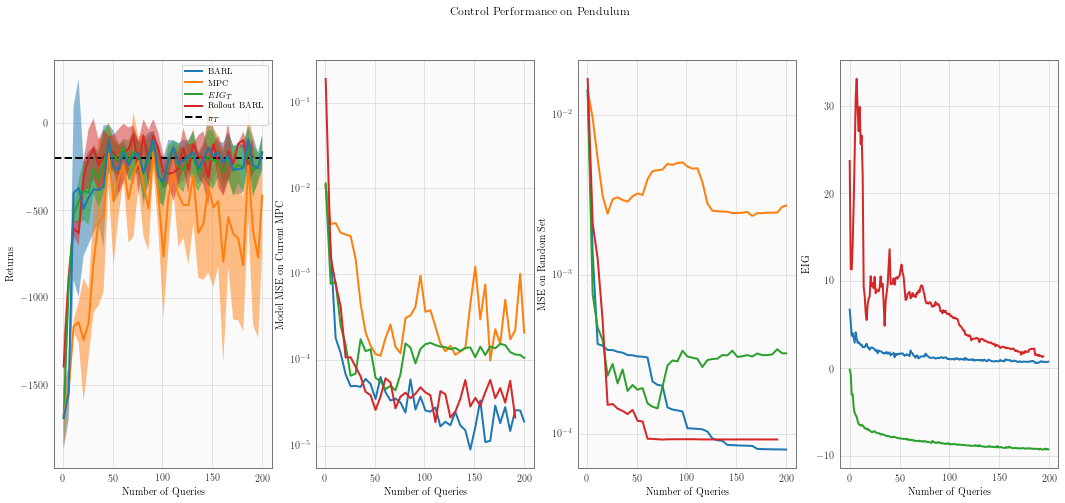

In [136]:
fig, [ax1, ax2, ax3, ax4] = plt.subplots(1, 4, figsize=(18, 7.5))
for i, (key, vals) in enumerate(data.items()):
    rmean = vals["Eval Mean Returns"]
    rstderr = vals["Eval Std Returns"]
    ndata = vals['Eval ndata']
    ax1.plot(ndata, rmean, label=key, zorder=100 - i)
    ax1.fill_between(ndata, rmean - rstderr, rmean + rstderr, alpha=0.5)
    if 'Model MSE' in vals:
        mses = vals['Model MSE']
        ax2.plot(ndata, mses, label=key)
    elif 'Model MSE (current MPC)' in vals:
        mses = vals['Model MSE (current MPC)']
        ax2.plot(ndata, mses, label=key)
    if 'Model MSE (random test set)' in vals:
        mses = vals['Model MSE (random test set)']
        ax3.plot(ndata, mses, label=key)
    if 'Acquisition Function Value' in vals:
        acqs = vals['Acquisition Function Value']
        ax4.plot(acqs, label=key)
    else:
        ax4.plot([], label=key)

        
ax1.set_xlabel('Number of Queries')
ax1.set_ylabel('Returns')
ax1.axhline(gt_val, color='black', linestyle='--', label=r'$\pi_T$')
ax1.legend()
ax2.set_xlabel('Number of Queries')
ax2.set_ylabel('Model MSE on Current MPC')
ax3.set_ylabel("MSE on Random Set")
ax3.set_xlabel('Number of Queries')
ax4.set_xlabel('Number of Queries')
ax4.set_ylabel('EIG')
if env_name == 'Lava Path':
    ax1.set_ylim(-1000, 0)
ax2.set_yscale('log')
ax3.set_yscale('log')
# ax1.set_xscale('log')

fig.suptitle(f"Control Performance on {env_name}")


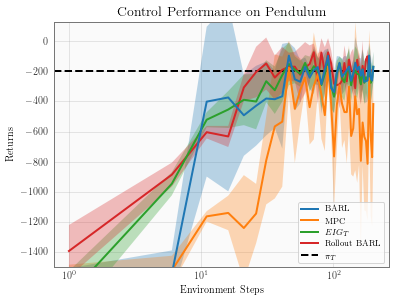

In [137]:
fig, ax = plt.subplots(figsize=(6, 4.5))
for i, (key, vals) in enumerate(data.items()):
    rmean = vals["Eval Mean Returns"]
    rstderr = vals["Eval Std Returns"]
    ndata = vals['Eval ndata']
    ax.plot(ndata, rmean, label=key, zorder=100 - i)
    ax.fill_between(ndata, rmean - rstderr, rmean + rstderr, alpha=0.3)
ax.set_xlabel('Environment Steps')
ax.set_ylabel('Returns')
ax.axhline(gt_val, color='black', linestyle='--', label=r'$\pi_T$')
ax.legend()
ylim_top = (gt_val - bottom_val) * 0.25 + gt_val
ax.set_ylim(bottom_val, ylim_top)
ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(0, 500)
# ax.set_ylim(-10000, 0)

title = f"Control Performance on {env_name}"
ax.set_title(label=title, fontdict={'fontsize': 14})
# fig.suptitle()
plt.savefig(f'sample_complexity_{env_name}.pdf') #, bbox_inches='tight')

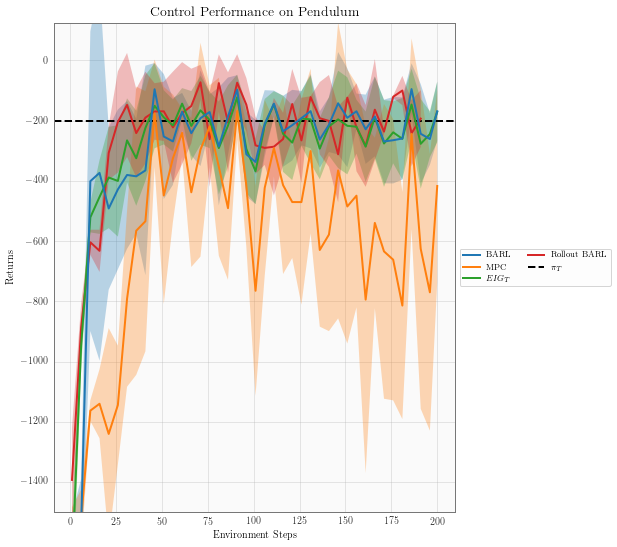

In [138]:
fig, ax = plt.subplots(figsize=(12, 9))
for i, (key, vals) in enumerate(data.items()):
    rmean = vals["Eval Mean Returns"]
    rstderr = vals["Eval Std Returns"]
    ndata = vals['Eval ndata']
    ax.plot(ndata, rmean, label=key, zorder=100 - i)
    ax.fill_between(ndata, rmean - rstderr, rmean + rstderr, alpha=0.3)
ax.set_xlabel('Environment Steps')
ax.set_ylabel('Returns')
ax.axhline(gt_val, color='black', linestyle='--', label=r'$\pi_T$')
# ax.legend()
ylim_top = (gt_val - bottom_val) * 0.25 + gt_val
ax.set_ylim(bottom_val, ylim_top)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(0, 500)
# ax.set_ylim(-10000, 0)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.6, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, fancybox=True)

title = f"Control Performance on {env_name}"
ax.set_title(label=title, fontdict={'fontsize': 14})
# fig.suptitle()
plt.savefig(f'legend_{env_name}.pdf') #, bbox_inches='tight')

In [139]:
print(f"Sample complexity of algorithms on {env_name}")
for key, vals in data.items():
    if 'Eval Seed Returns' in vals:
        samps = []
        for row in vals['Eval Seed Returns']:
            try:
                sample_idx = np.where(row > gt_val)[0].min()
                samps.append(vals['Eval ndata'][sample_idx])
            except ValueError:
                samps.append(np.inf)
        print(f"{key}: {sorted(samps)}")
        continue
    rmean = vals["Eval Mean Returns"]
    try:
        sample_idx = np.where(rmean > gt_val)[0].min()
        sample_complexity = vals['Eval ndata'][sample_idx]
    except ValueError:
        sample_complexity = None
    
    print(f"{key}: {sample_complexity}")

Sample complexity of algorithms on Pendulum
BARL: 46
MPC: 46
$EIG_T$: 46
Rollout BARL: 31.0


In [140]:
post_array = np.array(data['BARL (new)']['Posterior Returns'])
post_mean = post_array.mean(axis=1)
post_std = post_array.std(axis=1)
mean_array = data['BARL (new)']['Eval Mean Returns']
ndata = data['BARL (new)']['Eval ndata']
plt.plot(post_mean, label="Posterior Mean")
plt.plot(ndata, mean_array, label="Eval Mean", zorder=10)
plt.fill_between(range(len(post_mean)), post_mean - post_std, post_mean + post_std, alpha=0.3)
if env_name == 'Pendulum':
    plt.ylim(-2000, 0)

plt.legend()
plt.title(f'Posterior vs Actual Performance on {env_name}')

KeyError: 'BARL (new)'

In [ ]:
data['BARL']['Eval Mean Returns']


In [ ]:
data['BARL (new)']['Model MSE (current MPC)']